In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()


In [3]:
oddsratio_cutoff = 1.8
lgp_cutoff = 10
motif_enrichment_dir = '/home/hanliu/project/mouse_rostral_brain/study/ClustersEnsemble/HPFSubtypeEnsemble/MotifEnrichment/'
tf_class_level = 'SubFamily'

In [4]:
# Parameters
oddsratio_cutoff = 1.8
lgp_cutoff = 10
motif_enrichment_dir = "/home/hanliu/project/mouse_rostral_brain/study/ClustersEnsemble/CA1CA3DGEnsemble/MotifEnrichment"
tf_class_level = "SubFamily"


## Gene and motif metadata

In [5]:
motif_meta_with_cluster = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv',
    index_col='motif_uid'
)
gene_meta = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
                        sep='\t', index_col='gene_id')
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
tf_class.head()

,uid,GeneRawName,SuperClass,Class,Family,SubFamily,EnsemblID
0,1.1.1.1.1,c-Jun,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000052684
1,1.1.1.1.2,JunB,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,"ENSMUSG00000052837,ENSMUSG00000052926"
2,1.1.1.1.3,JunD,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000071076
3,1.1.1.2.1,NFE2,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000058794
4,1.1.1.2.2,NFE2L1,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000038615


In [6]:
levels = ['SuperClass', 'Class', 'Family', 'SubFamily']
for level in levels:
    gene_to_tf_class = {}
    for _, row in tf_class.iterrows():
        if isinstance(row['EnsemblID'], float):
            continue
        for g in row['EnsemblID'].split(','):
            gene_to_tf_class[g] = row[level]
    motif_meta_with_cluster[level] = motif_meta_with_cluster['gene_ids'].map(
        lambda i: gene_to_tf_class[i.split('.')[0]] if i.split('.')[0] in gene_to_tf_class else '')


## Motif Results

In [7]:
motif_results = list(pathlib.Path(motif_enrichment_dir).glob('**/*.motif_enrichment.msg'))
motif_results = pd.concat([pd.read_msgpack(path) for path in motif_results])
motif_results.index.name = 'MotifID'
motif_results.reset_index(inplace=True)
motif_results = pd.concat([motif_results, 
           motif_meta_with_cluster.loc[motif_results['MotifID']].reset_index(drop=True)], axis=1)

filtered_results = motif_results[(motif_results['oddsratio'] > oddsratio_cutoff) & 
                              (motif_results['-lgp'] > lgp_cutoff)].copy()


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  


In [8]:
# for each motif class in each group, select most significant ones
use_motif_for_clase_group = motif_results.groupby([tf_class_level, 'SubType']).apply(
    lambda i: i.sort_values('-lgp', ascending=False)['MotifID'].iloc[0])

In [9]:
# keep one motif for each group and each motif class
use_results = motif_results.set_index(['SubType', 'MotifID']).loc[[
    tuple(row.tolist())
    for _, row in use_motif_for_clase_group.reset_index().iloc[:, 1:].iterrows()
]].reset_index()
use_results = use_results[use_results[tf_class_level].fillna('') != ''].copy()

assert (use_results.groupby([tf_class_level, 'SubType']).apply(lambda i: i.shape[0]) != 1).sum() == 0

In [10]:
use_results.to_msgpack(f'{motif_enrichment_dir}/MotifEnrichment.agg.one_motif_per_class.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


In [11]:
# only keep motif class that has sig hits
sig_motif_class = filtered_results[tf_class_level].unique()
use_results = use_results[use_results[tf_class_level].isin(sig_motif_class)].copy()

In [12]:
motif_class_order = sorted([i for i in filtered_results[tf_class_level].dropna().unique() if i != ''])
cluster_order = sorted(use_results['SubType'].unique())

In [13]:
use_results = use_results[use_results[tf_class_level].isin(motif_class_order)]
use_results['x'] = use_results[tf_class_level].apply(lambda i: motif_class_order.index(i))
use_results['y'] = use_results['SubType'].apply(lambda i: cluster_order.index(i))
pass_filter_pairs = filtered_results.set_index(['MotifID', 'SubType']).index
use_results['sig'] = use_results.apply(lambda i: (i['MotifID'], i['SubType']) in pass_filter_pairs, axis=1)
# sync filter to region tfs
pass_filter_pairs = filtered_results[(filtered_results['-lgp'] > lgp_cutoff) & 
                                     (filtered_results['oddsratio'] > oddsratio_cutoff)].set_index(['MotifID', 'SubType']).index
use_results['sig'] = use_results.apply(lambda i: (i['MotifID'], i['SubType']) in pass_filter_pairs, axis=1)


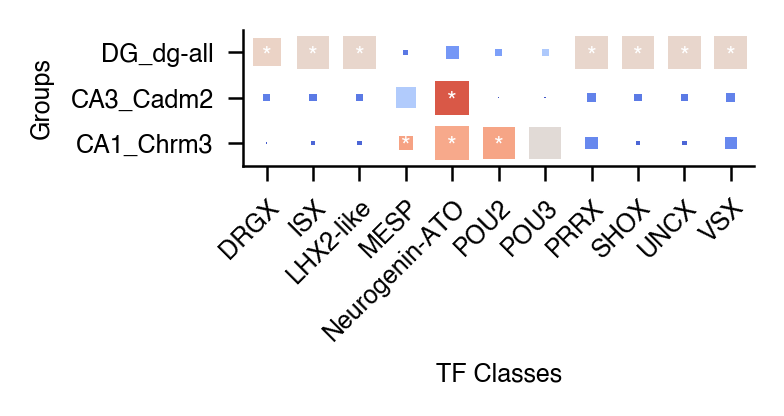

In [14]:
n_col = len(motif_class_order)
n_row = len(cluster_order)

fig, ax = plt.subplots(figsize=(n_col * 0.2, n_row * 0.2), dpi=300)
sns.scatterplot(ax=ax, data=use_results, x='x', y='y', 
                hue='oddsratio', hue_norm=(1, 2.5), palette='coolwarm', marker='s',
                size='-lgp', size_norm=(1, 100), sizes=(0.1, 65), linewidth=0, clip_on=False)

for _, row in use_results[use_results['sig']].iterrows():
    ax.text(row['x'], row['y']-0.1, '*', ha='center', va='center', fontsize=labelsize, c='white')

ax.set(xticks=range(n_col), xticklabels=[i[:20] for i in motif_class_order],
       yticks=range(n_row), yticklabels=cluster_order, ylim=(-0.5, n_row - .5), 
       xlabel='TF Classes', ylabel='Groups')


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
sns.despine(ax=ax)
ax.legend_.set_visible(False)

In [15]:
fig.savefig(f'{motif_enrichment_dir}/MotifEnrichment.dotmap.pdf', bbox_inches='tight')